# Feature Engineering with Linear Regression
We have tried a standard linear model as well as a model including dummy variables. In this activity, we will create some periodic features to try and get a better fit for the data. Periodic features are derived from functions that repeat over some range of the independent variable. In Figure 3.37, we can see that the data at the beginning of the year is near the same values and, in between, the temperature increases and then decreases. This is intuitively reasonable because we know that in temperate climates, there is an annual temperature cycle. Thus, we might improve the model if we include features that are periodic on a time scale of 1 year. We can construct sine and cosine functions that have the desired behavior.
When fitting a model with engineered periodic features, we face an additional challenge to determine how to line up the periodic cycle of the features to the actual data. You can think of this as a time offset in this case, which we don't know a priori. You could also think of the offset as a hyperparameter—fitting the model does not give us the value so we have to find the best value in some other way.



Fortunately, if we use sine and cosine functions for our features, there is a way to address this. It is a mathematical fact that any given sine function at a single period, such as the raw data in Figure 3.37, can be expressed as a linear combination of a sine and cosine function of the same period. In the next figure, we show a sine and cosine function, each with a period of 365 days, and the raw data from Figure 3.37. We also show a linear combination of the sine and cosine function that matches the raw data very well. Thus, to fit a sine (or cosine) function to our data, we simply need to engineer two features, one as the sine of the time, and the other as the cosine of the time. The linear regression will then find the best coefficients just like any other feature. Note that this implies we know the period.

The last thing we need to know is how to formulate the sine and cosine functions. For this, we can use the NumPy methods, **sin** and **cos**. We know we want a period of 1 year, and our data is in days. The correct way to write a sine function with a 365-day period is as follows:

$\sin_{365} = \sin(2*\pi* \frac{time}{365})$

Alternatively, in Python a sine function with a 365-day period is as follows:

**sin_365 = np.sin(2 \* np.pi \* df_one_year\['Day_of_Year'\] / 365)**

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [53]:
#
# load data
#
df = pd.read_csv('../Datasets/austin_weather.csv')

In [54]:
df = df.loc[:, ['Date', 'TempAvgF']]

In [55]:
#
# add some useful columns
#
df.loc[:, 'Year'] = df.loc[:, 'Date'].str.slice(0, 4).astype('int')
df.loc[:, 'Month'] = df.loc[:, 'Date'].str.slice(5, 7).astype('int')
df.loc[:, 'Day'] = df.loc[:, 'Date'].str.slice(8, 10).astype('int')

In [56]:
#
# set a 20 day window then use that to smooth 
# temperature in a new column
window = 20
df['MA'] = df.TempAvgF.rolling(window).mean()

In [57]:
#
# now let's slice exactly one year on the
# calendar start and end dates
# we see from the previous output that 
# 2014 is the first year with complete data, 
# however it will still have NaN values for 
# the moving average, so we'll use 2015
#
df_one_year = df.loc[df.Year == 2015, :].reset_index()
df_one_year['Day_of_Year'] = df_one_year.index + 1
df_one_year

,index,Date,TempAvgF,Year,Month,Day,MA,Day_of_Year
0,376,2015-01-01,37,2015,1,1,52.70,1
1,377,2015-01-02,41,2015,1,2,51.50,2
2,378,2015-01-03,51,2015,1,3,50.65,3
3,379,2015-01-04,43,2015,1,4,49.65,4
4,380,2015-01-05,41,2015,1,5,48.95,5
...,...,...,...,...,...,...,...,...
360,736,2015-12-27,55,2015,12,27,61.10,361
361,737,2015-12-28,41,2015,12,28,60.20,362
362,738,2015-12-29,43,2015,12,29,59.25,363
363,739,2015-12-30,49,2015,12,30,58.45,364


In [58]:
df_one_year['Sin_DoY'] = np.sin(2 *np.pi * df_one_year['Day_of_Year'] / 365)
df_one_year['Cos_DoY'] = np.cos(2 *np.pi * df_one_year['Day_of_Year'] / 365)
df_one_year

,index,Date,TempAvgF,Year,Month,Day,MA,Day_of_Year,Sin_DoY,Cos_DoY
0,376,2015-01-01,37,2015,1,1,52.70,1,1.721336e-02,0.999852
1,377,2015-01-02,41,2015,1,2,51.50,2,3.442161e-02,0.999407
2,378,2015-01-03,51,2015,1,3,50.65,3,5.161967e-02,0.998667
3,379,2015-01-04,43,2015,1,4,49.65,4,6.880243e-02,0.997630
4,380,2015-01-05,41,2015,1,5,48.95,5,8.596480e-02,0.996298
...,...,...,...,...,...,...,...,...,...,...
360,736,2015-12-27,55,2015,12,27,61.10,361,-6.880243e-02,0.997630
361,737,2015-12-28,41,2015,12,28,60.20,362,-5.161967e-02,0.998667
362,738,2015-12-29,43,2015,12,29,59.25,363,-3.442161e-02,0.999407
363,739,2015-12-30,49,2015,12,30,58.45,364,-1.721336e-02,0.999852


In [59]:
linear_model = LinearRegression(fit_intercept=True)
training_data = df_one_year[['Day_of_Year','Sin_DoY','Cos_DoY']]
target_values = df_one_year['TempAvgF']
linear_model.fit(training_data, target_values)
print('Coef: {}'.format(linear_model.coef_))
print('Intercept: {}'.format(linear_model.intercept_))
r2 = linear_model.score(training_data, target_values)
print('r2: {}'.format(r2))

Coef: [ 1.46396364e-02 -5.57332499e+00 -1.67824174e+01]
Intercept: 67.43327530313066
r2: 0.779745650129063


In [60]:
pred = linear_model.predict(training_data)

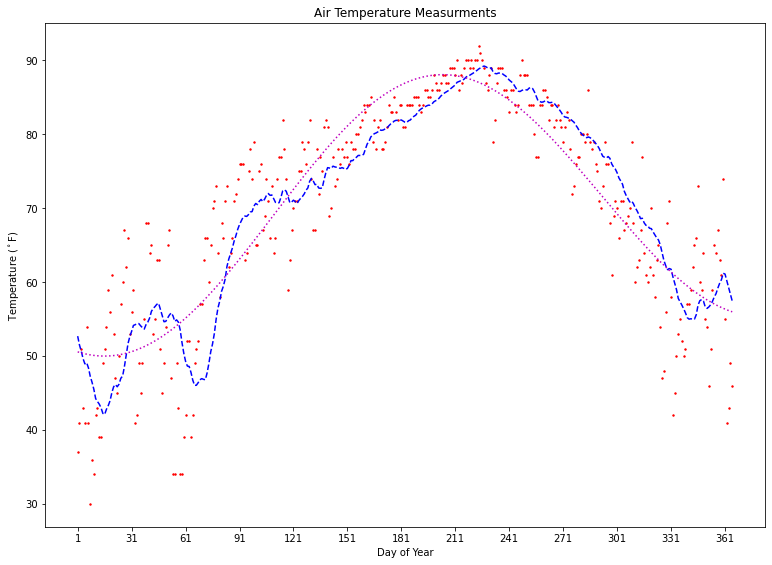

In [61]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])

# raw data
ax.scatter(
    x=df_one_year.Day_of_Year,
    y=df_one_year.TempAvgF,
    c='r',
    s=2,
    label='Raw Data',
)

# moving average
ax.plot(
    df_one_year.Day_of_Year,
    df_one_year.MA,
    c='b',
    linestyle='--',
    label='20 day moving average'
)

# periodic
ax.plot(
    df_one_year.Day_of_Year,
    pred,
    c='m',
    linestyle=':',
    label='linear mode with sin-cos fit'  
)

ax.set_xticks(range(df_one_year.Day_of_Year.min(), 
                    df_one_year.Day_of_Year.max(), 
                    30))
ax.set_xlabel('Day of Year')
ax.set_ylabel('Temperature ($^\circ$F)')
ax.set_title('Air Temperature Measurments')

plt.show()